## Predicting drive failure with XGBoost and RAPIDS

**Dataset**: Hard disk SMART data and failure dataset from Backblaze ([More information](https://www.backblaze.com/b2/hard-drive-test-data.html))

**Task**: Predict hard disk failure with RAPIDS

In [1]:
! pip install tqdm matplotlib gpustat

     |################################| 51kB 6.4MB/s 


In [2]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

# RAPIDS
import cudf
import xgboost as xgb

In [3]:
# download our training and evaluation data
!wget -nc https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/train.csv
!wget -nc https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/eval.csv

--2019-05-13 03:46:00--  https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/train.csv
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.40.81
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.40.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23739943 (23M) [text/csv]
Saving to: 'train.csv'

train.csv           100%[===================>]  22.64M  8.39MB/s    in 2.7s    

2019-05-13 03:46:04 (8.39 MB/s) - 'train.csv' saved [23739943/23739943]

--2019-05-13 03:46:05--  https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/eval.csv
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.40.81
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.40.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6892135 (6.6M) [text/csv]
Saving to: 'eval.csv'

eval.csv          

### 1. Load Data

#### Training Data

Use Pandas to load training data from CSV. This consists of the pre-processed drive data from **January 2015** to **September 2018**.

In [4]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16770 entries, 0 to 16769
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 40.7 MB


Split into features (`df_train`) and labels(`df_target`), where each is a Pandas `Dataframe`.

In [5]:
df_train = df.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_train_target = pd.DataFrame(df["failure"]).apply(pd.to_numeric)

#### Evaluation Data

Do the same thing to load evaluation data from CSV.

In our case, this consists of the pre-processed drive data from **October 2018 to December 2018**.

In [6]:
df_t = pd.read_csv("eval.csv")
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4527 entries, 0 to 4526
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 11.0 MB


In [7]:
df_test = df_t.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_test_target = pd.DataFrame(df_t["failure"]).apply(pd.to_numeric)

### 2. Model Parameters

In [8]:
MAX_TREE_DEPTH = 10
TREE_METHOD = 'hist'
ITERATIONS = 120
SUBSAMPLE = 0.8
REGULARIZATION = 1.4
GAMMA = 0.4
POS_WEIGHT = 0.8
EARLY_STOP = None

### 3. Train with CPU

XGBoost training with CPU (`params[tree_method] = 'hist'`), using a Pandas `Dataframe` loaded into `xgb.DMatrix`. For more information, check out [this page in the XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

As we can see, training with even a high-end Intel Xeon CPU is pretty slow!

In [9]:
!lscpu | grep 'Model name:'
!lscpu | grep 'CPU(s)'

Model name:            Intel(R) Xeon(R) CPU E5-2698 v3 @ 2.30GHz
CPU(s):                64
On-line CPU(s) list:   0-31
Off-line CPU(s) list:  32-63
NUMA node0 CPU(s):     0-15
NUMA node1 CPU(s):     16-31


In [10]:
start_time = time.time()

xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)

params = {'tree_method': TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_cpu = time.time() - start_time

# free up memory
del xgtrain
del bst

[0]	train-rmse:0.484645	eval-rmse:0.482874
[1]	train-rmse:0.470413	eval-rmse:0.466816
[2]	train-rmse:0.457102	eval-rmse:0.452582
[3]	train-rmse:0.444752	eval-rmse:0.437972
[4]	train-rmse:0.433335	eval-rmse:0.42463
[5]	train-rmse:0.422742	eval-rmse:0.412813
[6]	train-rmse:0.412927	eval-rmse:0.401007
[7]	train-rmse:0.403715	eval-rmse:0.390577
[8]	train-rmse:0.395206	eval-rmse:0.380392
[9]	train-rmse:0.387268	eval-rmse:0.37212
[10]	train-rmse:0.37999	eval-rmse:0.362625
[11]	train-rmse:0.373443	eval-rmse:0.353973
[12]	train-rmse:0.367512	eval-rmse:0.346046
[13]	train-rmse:0.36188	eval-rmse:0.338827
[14]	train-rmse:0.356754	eval-rmse:0.331773
[15]	train-rmse:0.352014	eval-rmse:0.32522
[16]	train-rmse:0.347603	eval-rmse:0.319345
[17]	train-rmse:0.343501	eval-rmse:0.313636
[18]	train-rmse:0.339799	eval-rmse:0.308468
[19]	train-rmse:0.336476	eval-rmse:0.303938
[20]	train-rmse:0.333339	eval-rmse:0.299364
[21]	train-rmse:0.330495	eval-rmse:0.296466
[22]	train-rmse:0.327894	eval-rmse:0.293518
[23

In [11]:
print("CPU Time Taken:\n", round(timetaken_cpu,1))

CPU Time Taken:
 30.0


### 4. Train with GPU

To use GPU, we set `params[tree_method] = 'gpu_hist'`. Use full RAPIDS stack by using XGBoost with cuDF for additional speedup. To do this, we load the Pandas `Dataframe` into a cuDF Dataframe (Python object type `cudf.dataframe.dataframe.DataFrame`).

In [12]:
# load into cuDF Dataframe

gdf_train = cudf.DataFrame.from_pandas(df_train)
gdf_train_target = cudf.DataFrame.from_pandas(df_train_target)

gdf_eval = cudf.DataFrame.from_pandas(df_test)
gdf_eval_target = cudf.DataFrame.from_pandas(df_test_target)

print("Moved data to GPU")

Moved data to GPU


In [13]:
# GPU, with using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time

[0]	train-rmse:0.484504	eval-rmse:0.482751
[1]	train-rmse:0.470022	eval-rmse:0.466864
[2]	train-rmse:0.456599	eval-rmse:0.452001
[3]	train-rmse:0.444145	eval-rmse:0.438056
[4]	train-rmse:0.432609	eval-rmse:0.424207
[5]	train-rmse:0.421834	eval-rmse:0.411847
[6]	train-rmse:0.411809	eval-rmse:0.401551
[7]	train-rmse:0.402615	eval-rmse:0.391015
[8]	train-rmse:0.39408	eval-rmse:0.381742
[9]	train-rmse:0.38609	eval-rmse:0.3724
[10]	train-rmse:0.37875	eval-rmse:0.36445
[11]	train-rmse:0.372111	eval-rmse:0.356776
[12]	train-rmse:0.365946	eval-rmse:0.349015
[13]	train-rmse:0.36017	eval-rmse:0.342638
[14]	train-rmse:0.354933	eval-rmse:0.33673
[15]	train-rmse:0.34997	eval-rmse:0.329801
[16]	train-rmse:0.34542	eval-rmse:0.323589
[17]	train-rmse:0.341307	eval-rmse:0.318515
[18]	train-rmse:0.337414	eval-rmse:0.313803
[19]	train-rmse:0.333892	eval-rmse:0.308947
[20]	train-rmse:0.330611	eval-rmse:0.305094
[21]	train-rmse:0.327446	eval-rmse:0.30081
[22]	train-rmse:0.324675	eval-rmse:0.297699
[23]	trai

In [15]:
print("Check GPU memory usage")
!gpustat

Check GPU memory usage
/bin/sh: 1: gpustat: not found


### 5. Results

We see a significant speed-up when we use the RAPIDS stack.

In [16]:
print("CPU Time Taken:\n", round(timetaken_cpu,1))
print("\nGPU + cuDF Time Taken:\n", round(timetaken_gpu,1))
print("\nTotal speed-up with RAPIDS:\n", round(timetaken_cpu/timetaken_gpu*100,1), "%")

CPU Time Taken:
 30.0

GPU + cuDF Time Taken:
 2.0

Total speed-up with RAPIDS:
 1502.7 %


Let's look at the model's performance on the evalutation set

In [17]:
preds = bst.predict(xgeval)

y_pred = []

THRESHOLD = 0.5

for pred in preds:
    if pred<=THRESHOLD:
        y_pred.append(0)
    if pred>THRESHOLD:
        y_pred.append(1)

y_pred = np.asarray(y_pred)
        
y_true = df_test_target.values.reshape(len(preds))

In [18]:
print("Accuracy (Eval)", round(accuracy_score(y_true, y_pred),3))

Accuracy (Eval) 0.946


In [19]:
print(classification_report(y_true, y_pred, target_names=["normal", "fail"]))

              precision    recall  f1-score   support

      normal       0.97      0.97      0.97      4208
        fail       0.62      0.60      0.61       319

   micro avg       0.95      0.95      0.95      4527
   macro avg       0.80      0.78      0.79      4527
weighted avg       0.94      0.95      0.95      4527



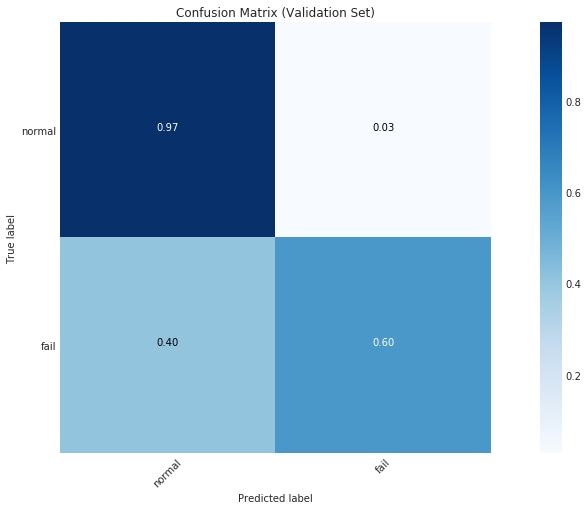

In [20]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, labels=["normal", "fail"])